# Drug Classification Study
This study looks to classify drugs based on an indivuduals health data. While the dataset is fairly simple, the purpose of this notebook is to build a template for:

- Exploratory data analysis
- Building column transformers to process different data types
- Building pipelines combining column transformers and classifiers
- Building a neural network generator to use in combination with GridSearchCV
- Testing and analysing the performance of multiple models

## Setup

In [166]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.svm import SVC

## Import Data and Create Datasets

In [128]:
# Import and inspect the data
drug_df = pd.read_csv('drug200.csv')

In [129]:
drug_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


The summary above suggests that all the fields are fully populated and hence data imputing will not be required.

In [130]:
# Prepare train, test and validation sets
train_df, test_df = train_test_split(drug_df, test_size = 0.1, random_state = 23)

In [131]:
X_train = train_df.drop('Drug', axis = 1).reset_index().drop(columns = ['index']).copy()
y_train = train_df[['Drug']].reset_index().drop(columns = ['index']).copy()
X_test = test_df.drop('Drug', axis = 1).reset_index().drop(columns = ['index']).copy()
y_test = test_df[['Drug']].reset_index().drop(columns = ['index']).copy()

## Exploratory Data Analysis

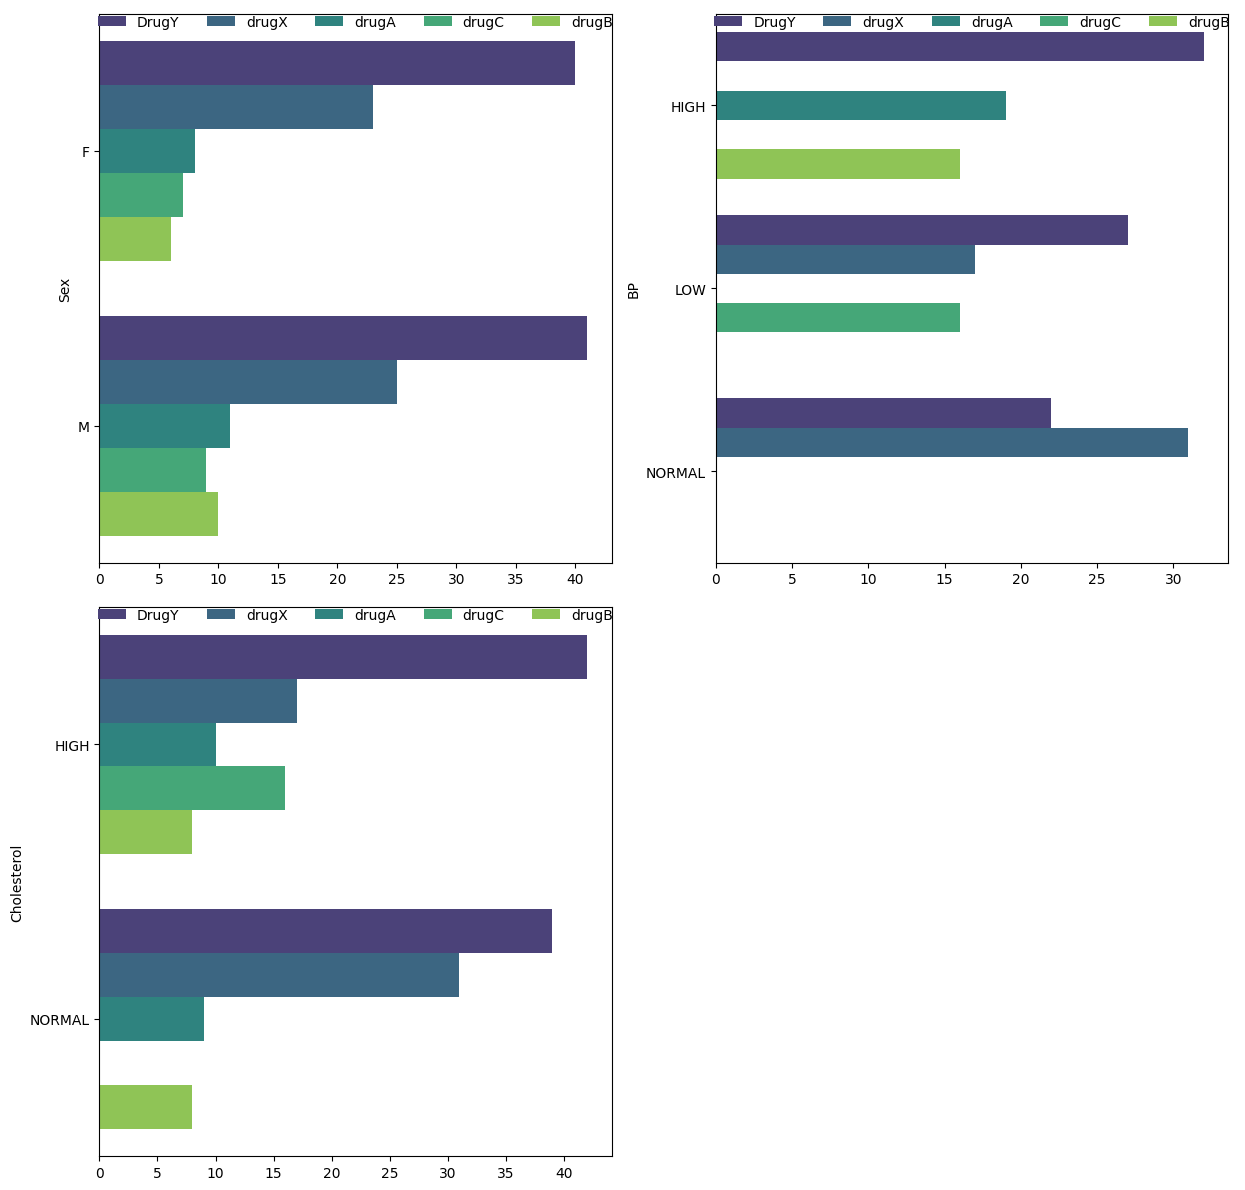

In [133]:
cat_cols = ['Sex', 'BP', 'Cholesterol']

fig = plt.figure(figsize = (12, 12))
fig.tight_layout()
p = 1

for col in cat_cols:
    ax = fig.add_subplot(2, 2, p)
    fig.tight_layout()
    sns.countplot(
    data = train_df, y = col, hue = 'Drug', palette = 'viridis', ax = ax
    )
    ax.set(xlabel = None, ylabel = col)
    sns.move_legend(ax, "lower center", bbox_to_anchor = (.5, 0.95), ncol = 5, title = None, frameon = False,)
    p += 1

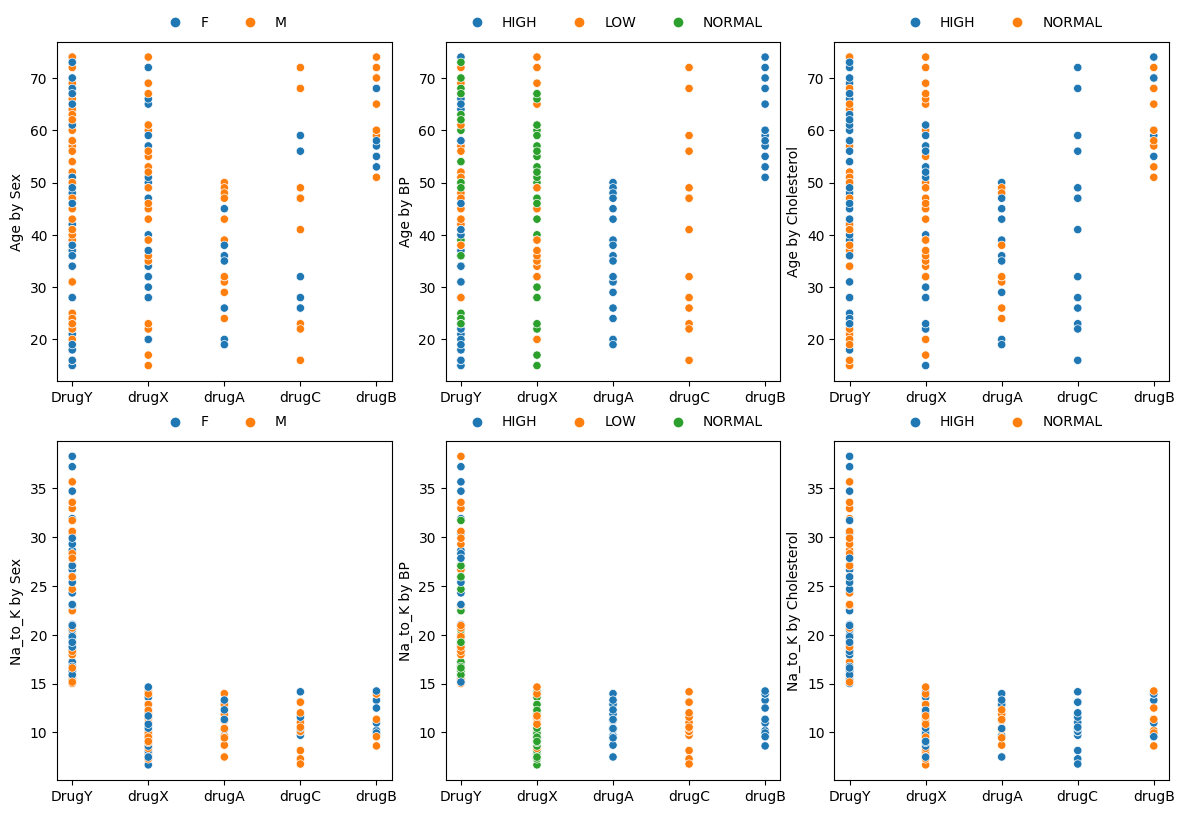

In [134]:
cont_cols = ['Age', 'Na_to_K']
fig = plt.figure(figsize = (12, 12))
fig.subplots_adjust()
r = 1
for col in cont_cols:
    for cat_col in cat_cols:
        ax = fig.add_subplot(3, 3, r)
        fig.tight_layout(h_pad = 0.3, w_pad = 0.1)
        sns.scatterplot(data = train_df, x = 'Drug', y = col, hue = cat_col, ax = ax)
        sns.move_legend(ax, "lower center", bbox_to_anchor = (.5, 1), ncol = 3, title = None, frameon = False,)
        ax.set(xlabel = None, ylabel = col + ' by ' + cat_col)
        r += 1
        

Data is linearly seperable as can be seen in the graphs. For instance, Drug Y is used in patients with Na to K ratios of above 15. Drug C is for patients with low BP and high cholesterol with Na to K ratio below 15. 

Such clear linear seperation between Drugs should make classification relatively straight forward. With complete data, models such as XGBoost and SVMs should work quite well due to their process of drawing clear demarcations between classes. 

Neural Networks will also perform well, however models such as XGBoost and SVMs tend to perform stronger in cases with smaller datasets and clear linear demarcation. Neural Networks tend to perform better than other ML models where there are less obvious patterns, large training datasets and potentially non-linear seperation (such as temporal or spatial seperation).

## Data Transformation

In [135]:
# Build transformers and pipelines
label_enc = LabelEncoder()

In [136]:
binary_qual_cols = ['Sex']
hnl_qual_cols = ['BP', 'Cholesterol']

hnl_ord_enc = OrdinalEncoder(categories = [['HIGH', 'NORMAL', 'LOW'], ['HIGH', 'NORMAL', 'LOW']])
cat_enc = OrdinalEncoder()

qual_cols_transformer = ColumnTransformer(transformers = [
    ('cat_enc', cat_enc, binary_qual_cols),
    ('hnl_ord_enc', hnl_ord_enc, hnl_qual_cols)
], remainder = 'passthrough')

In [137]:
data_process_pipe = Pipeline(steps = [
    ('qual_cols_transformer', qual_cols_transformer),
    ('scaler', StandardScaler())
])

Data transformations are applied to suit all models below. Note that standardization is not required for models such as XGBoost (where the seperation process is not based on Euclidean distance between observations). However making this transformation should not impact its performance.

## Model Building

In [144]:
# Create neural network model builder
def build_model(n_hidden, n_neurons, input_shape):
    
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape = input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation = 'relu'))
    model.add(keras.layers.Dense(5))
    
    return model

nn_model = KerasClassifier(
    model = build_model,
    loss = 'sparse_categorical_crossentropy',
    optimizer = keras.optimizers.SGD(learning_rate = 0.01),
    epochs = 500, 
    batch_size = 30, 
    verbose = 0,
    n_hidden = 1, 
    n_neurons = 30,
    input_shape = [5])

In [145]:
# Create basic XGBoost pipeline
clf_pipe_xgb = Pipeline(steps = [
    ('data_process_pipe', data_process_pipe),
    ('model', XGBClassifier())]
)

In [146]:
# Create NN pipeline
clf_pipe_nn = Pipeline(steps = [
    ('data_process_pipe', data_process_pipe),
    ('model', nn_model)]
)

In [167]:
# Create SVM pipeline
clf_pipe_svm = Pipeline(steps = [
    ('data_process_pipe', data_process_pipe),
    ('model', SVC(gamma = 'auto'))]
)

In [147]:
# Label encoding
y_train_enc = label_enc.fit_transform(y_train.squeeze())
y_test_enc = label_enc.transform(y_test.squeeze())

## Training Models and Performance Analysis

In [148]:
# Fit the XGBoost classifier pipeline
clf_pipe_xgb.fit(X_train, y_train_enc)

Pipeline(steps=[('data_process_pipe',
                 Pipeline(steps=[('qual_cols_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cat_enc',
                                                                   OrdinalEncoder(),
                                                                   ['Sex']),
                                                                  ('hnl_ord_enc',
                                                                   OrdinalEncoder(categories=[['HIGH',
                                                                                               'NORMAL',
                                                                                               'LOW'],
                                                                                              ['HIGH',
                                                                                               'NORMAL',
                                                                                               'LOW']]),
                                                                   ['BP',
                                                                    'Cholesterol'])])),
                                 ('scaler', StandardScaler())])),
                ('model',
                 XGBClassifier(base_sco...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1,
                               objective='multi:softprob', predictor='auto', ...))])

In [168]:
y_pred_xgb = clf_pipe_xgb.predict(X_test)

In [169]:
xgb_conf_mat = confusion_matrix(y_test_enc, y_pred_xgb)
xgb_conf_mat

array([[10,  0,  0],
       [ 0,  4,  0],
       [ 0,  0,  6]])

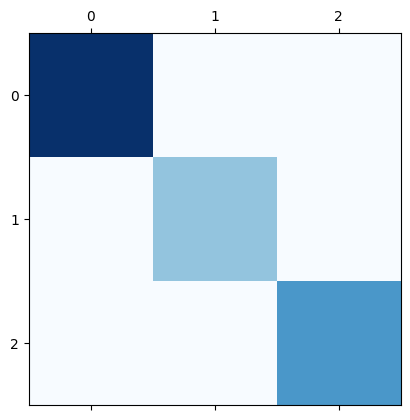

In [170]:
plt.matshow(xgb_conf_mat, cmap = plt.cm.Blues)
plt.show()

In [171]:
accuracy_score(y_test_enc, y_pred_xgb)

1.0

In [172]:
# Fit the SVM classifier pipeline
clf_pipe_svm.fit(X_train, y_train_enc)

Pipeline(steps=[('data_process_pipe',
                 Pipeline(steps=[('qual_cols_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cat_enc',
                                                                   OrdinalEncoder(),
                                                                   ['Sex']),
                                                                  ('hnl_ord_enc',
                                                                   OrdinalEncoder(categories=[['HIGH',
                                                                                               'NORMAL',
                                                                                               'LOW'],
                                                                                              ['HIGH',
                                                                                               'NORMAL',
                                                                                               'LOW']]),
                                                                   ['BP',
                                                                    'Cholesterol'])])),
                                 ('scaler', StandardScaler())])),
                ('model', SVC(gamma='auto'))])

In [173]:
y_pred_svm = clf_pipe_svm.predict(X_test)

In [174]:
svm_conf_mat = confusion_matrix(y_test_enc, y_pred_svm)
svm_conf_mat

array([[10,  0,  0],
       [ 0,  4,  0],
       [ 0,  0,  6]])

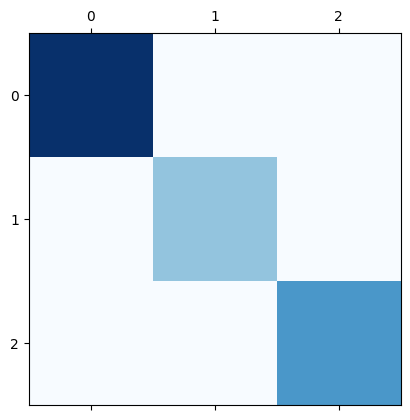

In [175]:
plt.matshow(svm_conf_mat, cmap = plt.cm.Blues)
plt.show()

In [176]:
accuracy_score(y_test_enc, y_pred_svm)

1.0

In [160]:
# Create GridSearchCV setup to test various configurations of neural network classification model
params = {
    'model__n_neurons': [30, 50],
    'model__n_hidden': [4, 5],
    'model__batch_size': [90, 180],
    'model__epochs': [100, 200],
    'model__optimizer': ['sgd', 'adam'],
    'model__optimizer__learning_rate': [0.0001, 0.001, 0.1]
}
gs = GridSearchCV(clf_pipe_nn, params, refit = True, scoring = 'accuracy', verbose = 1, cv = 3)

gs.fit(X_train, y_train_enc)
print(gs.best_score_, gs.best_params_)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
0.7277777777777779 {'model__batch_size': 180, 'model__epochs': 200, 'model__n_hidden': 4, 'model__n_neurons': 50, 'model__optimizer': 'adam', 'model__optimizer__learning_rate': 0.001}


In [177]:
best_estimator = gs.best_estimator_

In [178]:
# Analyse output
y_test_preds = best_estimator.predict(X_test)

In [180]:
nn_conf_mat = confusion_matrix(y_test_enc, y_test_preds)
nn_conf_mat

array([[10,  0,  0],
       [ 0,  4,  0],
       [ 1,  0,  5]])

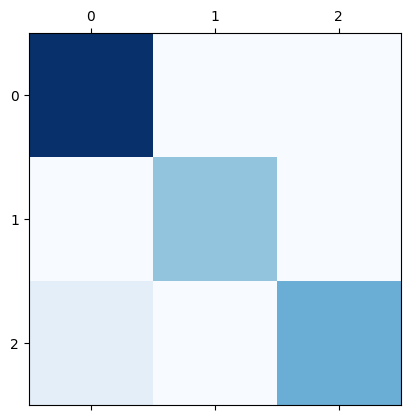

In [181]:
plt.matshow(nn_conf_mat, cmap = plt.cm.Blues)
plt.show()

In [182]:
accuracy_score(y_test_enc, y_test_preds)

0.95

In summary, it was seen that XGBoost and SVM performed extremely well with perfect classification (without any hyperparameter tuning!). As mentioned earlier, the clear linear seperation enables this level of performance. The neural network in comparison, performed slightly worse with an accuracy score of 0.95 (as opposed to 1 for the others).

There may be better ways of training the Neural Network to achieve higher accuracy scores such as to classify one drug only (which is hardest for it to classify) and then to use the model weights for a deeper layer in the final model. However, with the strong performance of XGBoost or SVM, it would be more prudent to just use those for this classification study!